In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from pqcd.utils import (
    to_GeV_per_cubic_femtometre,
    to_nucleons_per_cubic_femtometre,
    nsat,
    rcparams
    )
plt.rcParams.update(rcparams)

In [2]:
pqcd_region = pqcd.get_pqcd_region()

In [3]:
def plot_eos(set, variety, n, c, ax, mu_mark, label_mu=False):

    eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/eos-draw-{n:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    chemical_potential = (energy_density+pressure)/number_density

    # Interpolate over chemical potential
    pressure_interp = np.interp(pqcd_region['mu_array'], chemical_potential, pressure)
    number_density_interp = np.interp(pqcd_region['mu_array'], chemical_potential, number_density)

    ax.plot(
        number_density/nsat,
        pressure,
        c='k',
        alpha=0.5,
    )
    ax.plot(
        number_density_interp/nsat,
        pressure_interp, 
        c=c
        )
    ax.plot(
        number_density_interp[0]/nsat,
        pressure_interp[0],
        marker='o',
        c=c,
        markersize=5,
    )
    ax.plot(
        number_density_interp[-1]/nsat,
        pressure_interp[-1],
        marker='o',
        c=c,
        markersize=5,
    )
    if label_mu:
        ax.text(
            number_density_interp[0]/nsat,
            pressure_interp[0]+0.05,
            '$\mu = 2.4\,\mathrm{GeV}$',
            horizontalalignment='center',
            verticalalignment='bottom',
            fontsize=11,
            rotation=36,
            rotation_mode='anchor',
        )
        ax.text(
            number_density_interp[-1]/nsat,
            pressure_interp[-1]+0.05,
            '$\mu = 2.6\,\mathrm{GeV}$',
            horizontalalignment='center',
            verticalalignment='bottom',
            fontsize=11,
            rotation=40,
            rotation_mode='anchor',
        )
    for mu in mu_mark:
        p_at_mu = pressure_interp[np.argmin(np.abs(pqcd_region['mu_array']-mu))]
        n_at_mu = number_density_interp[np.argmin(np.abs(pqcd_region['mu_array']-mu))]
        ax.plot(
            n_at_mu/nsat,
            p_at_mu,
            marker='o',
            c=c,
            markersize=3,
        )

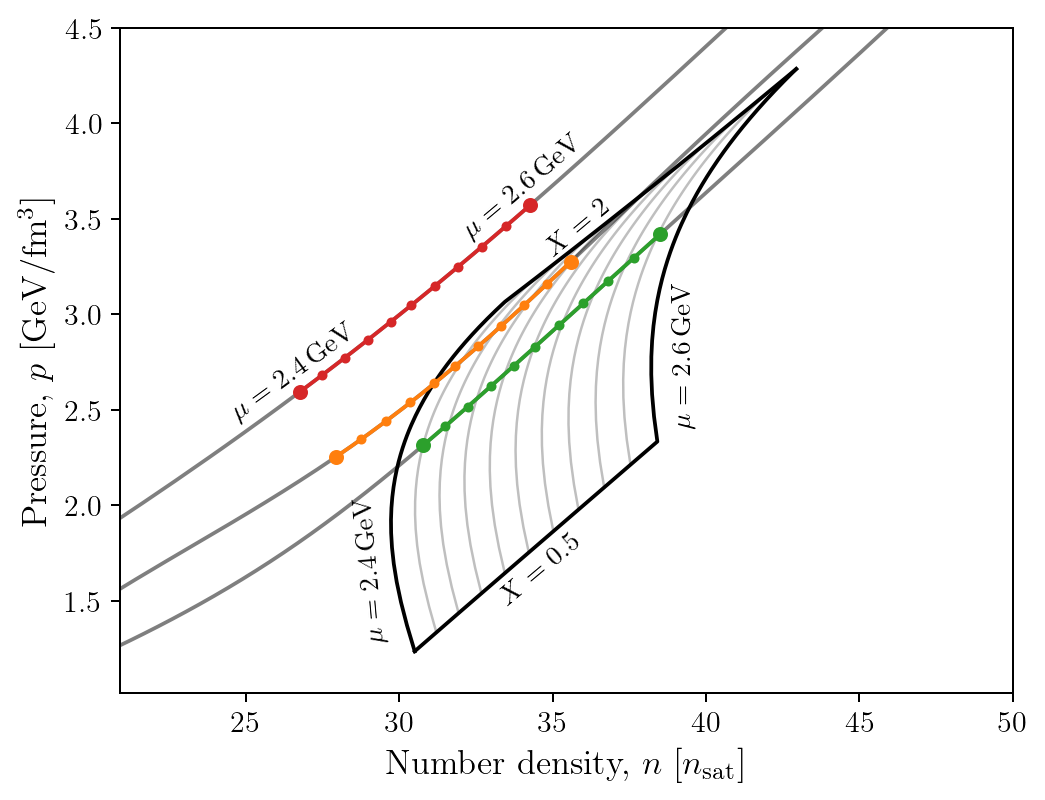

In [4]:
mu_mark = np.arange(2.42, 2.58, 0.02)

fig, ax = plt.subplots(dpi=180)

# pQCD region boundaries
# ----------------------

ax.plot(
    pqcd_region['left_n_boundary']/nsat, 
    pqcd_region['left_p_boundary'], 
    'k'
    )
ax.plot(
    pqcd_region['right_n_boundary']/nsat, 
    pqcd_region['right_p_boundary'], 
    'k'
    )

# Constant mu lines at each mu_mark
# ---------------------------------

for mu in mu_mark:

    p_boundary_array = np.zeros(len(pqcd_region['X_array']))
    n_boundary_array = np.zeros(len(pqcd_region['X_array']))

    for i, X in enumerate(pqcd_region['X_array']):
        pQCDX = pqcd.pQCD(X)
        p_boundary_array[i] = pQCDX.pH(mu)
        n_boundary_array[i] = pQCDX.nH(mu)

    ax.plot(
        n_boundary_array/nsat,
        p_boundary_array, 
        alpha=0.25, 
        c='k',
        zorder=0.1,
        linewidth=1
    )

# An EOS which doesn't overlap the region at all
# ----------------------------------------------

set = 0
variety = 'hyp'
n = 8

plot_eos(set, variety, n, 'C3', ax, mu_mark, label_mu=True)

# An EOS which overlaps the region but doesn't pass through it
# ------------------------------------------------------------

set = 0
variety = 'qrk'
n = 473

plot_eos(set, variety, n, 'C1', ax, mu_mark)

# An EOS which passes through the region
# --------------------------------------

set = 0
variety = 'qrk'
n = 184

plot_eos(set, variety, n, 'C2', ax, mu_mark)

# Labels
# ------

ax.text(33.5, 1.47, '$X = 0.5$', fontsize=11, rotation=40, rotation_mode='anchor')
ax.text(35, 3.3, '$X = 2$', fontsize=11, rotation=40, rotation_mode='anchor')

ax.text(29.5, 1.28, '$\mu = 2.4\,\mathrm{GeV}$', fontsize=11, rotation=95, rotation_mode='anchor')
ax.text(39.5, 2.4, '$\mu = 2.6\,\mathrm{GeV}$', fontsize=11, rotation=90, rotation_mode='anchor')

ax.set_xlim((20.899241856209166, 50))
ax.set_ylim((1.0183050679544774, 4.5))

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')